# Summary
___
The goal of using clustering to build our feature vector is to account for permutation in the particles that are assigned to each physics event. We create the feature vector by using k-means clustering to assign each particle to a cluster. Then for each event we find the number of particles assigned to each cluster and use that as our feature vector. This clustering then counting is permutation invariant which our current method is prone to and so we should see better performance. 

In [1]:
import preprocess
import Cluster
%matplotlib inline
import imp
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import cluster_learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.decomposition import PCA

In [2]:
df = preprocess.process_container_folder('cmsdata-2', '5-param')


First we'd like to determine a reasonable number of clusters to use for k-means clustering. I plotted the average distance from all the points to their nearest clusters as a function of the number of clusters. As the number of clusters increases the average distance will drop, and we are looking for points at which there is a sharp decrease in the average distance. This indicates that the number of clusters at that x-value is a good fit. Although from the graph we can see that it elbows around 5 or 6 clusters, later when classifying I found that many more clusters improved the classification.

In [3]:
max_cluster = 20
y = Cluster.find_best_cluster(df.loc[:,'pt':'evt'], max_cluster)
x = range(1,max_cluster)



Completed: training...
Computed: centroids...
Computed: distances...


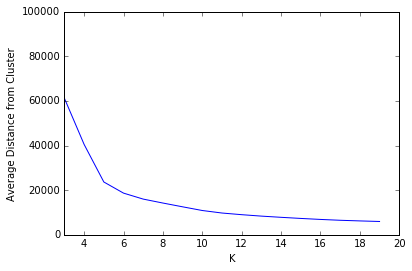

In [4]:
plt.figure(1)
plt.axis([3,max_cluster, 0, 10**5])
plt.xlabel("K")
plt.ylabel("Average Distance from Cluster")
plt.plot(x,y)


Then to see how well the clustering is performing and if k means is the suitable clustering method we can visualize the data colored by its respective cluster. The data is projected down into 3 dimensions by PCA for visualization purposes.

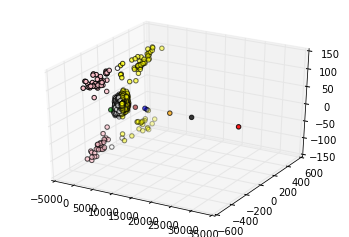

In [16]:
fig = plt.figure(2)
ax = fig.gca(projection='3d')
pca = PCA(n_components = 3)
trans_df = pca.fit_transform(df.loc[:,'pt':'dz'])
trans_df = pd.DataFrame(trans_df)
predictions = KMeans(n_clusters = 10, random_state = 3).fit_predict(df.loc[:,'pt':'dz'])
colors = Cluster.convert_label_to_color(predictions)

x = np.array(trans_df.iloc[:,0])
y = np.array(trans_df.iloc[:,1])
z = np.array(trans_df.iloc[:,2])
ax.scatter(xs = x,ys = y,zs = z, c = colors)
plt.show()

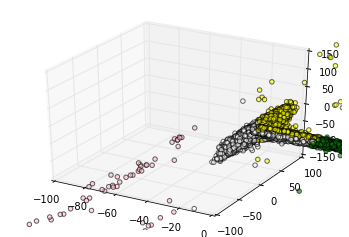

In [17]:
fig = plt.figure(3)
ax = fig.gca(projection='3d')
ax.scatter(xs = x,ys = y,zs = z, c = colors)
ax.set_xlim3d(-100, 0)
ax.set_ylim3d(-100,100)
ax.set_zlim3d(-150,150)
plt.show()

Zooming in on the origin to see the main clusters more closely. 

Now for classifcation we cluster the data by event and count how many particles belong to each cluster. After experimenting, a large number of clusters on the order of $10^3$ produces the best results for classification. This is likely because many clusters preserve most of the information of the particle while keeping the classifier permuation invariant. The accuracy increased monotonically with the number of clusters as far as I could test. With more computational power we could push the number of clusters higher to see if that yields even better results. 

In [18]:
x_data, labels = cluster_learning.bag_clusters(df, 100, .4)

In [20]:
 x_tr, x_tst, y_tr, y_tst = train_test_split(x_data, labels, test_size=0.2, random_state=3)

In [21]:
clf = RandomForestClassifier(n_estimators = 500)
clf.fit(x_tr, y_tr)
clf.score(x_tst,y_tst)

0.8516912402428447

An accuracy of .85 is a .10 increase over the concatenation method for creating our feature vector. It could possibly be improved with more clusters with more computational power, which is something that can be further investigated.

Below I have plotted the feature vectors after performing PCA and projecting them into 3 dimensions. They are colored by their correct labels. We can see the cluster for each classification is quite distinct even in 3 dimensions.

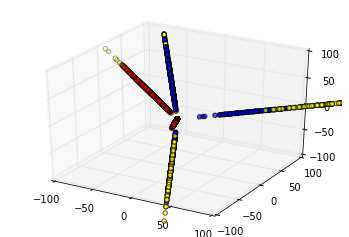

In [22]:
colors3 = Cluster.convert_label_to_color(labels)
pca = PCA(n_components = 3)
trans_df = pca.fit_transform(x_data)
trans_df = pd.DataFrame(trans_df)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(xs = trans_df.iloc[:,0],ys = trans_df.iloc[:,1],zs = trans_df.iloc[:,2], c = colors3)
ax.set_xlim3d(-100,100)
ax.set_ylim3d(-100,100)
ax.set_zlim3d(-100,100)
plt.show()